<a href="https://colab.research.google.com/github/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications/blob/ed_branch/Ed_LLM_FineTuning_PubMedQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalized Healthcare QA System (Chatbot) - V3 - PubMedQA
#### Ed:215279167
---
### Objective:
Develop a healthcare chatbot that answers patient inquiries on medications, symptoms, and  treatments while reducing hallucinations.

### Update and changes:
This updated notebook reflects changes learned from weeks 1 -7 experiments with fine-tuning. Main changes include:
* Use single dataset of PubMedQA. Initial attempts to use a combination of MedDialog and PubMedQA didn't provide significant improvements in evaluation, and beleive this is due to differing data quality in MedDialog dataset.
* Significant increase of data used for fine-tuning

### Datasets:
* PubMedQA – Biomedical QA dataset - https://huggingface.co/datasets/qiaojin/PubMedQA

### Task Breakdown:
1. Train models on medical QA datasets.
2. Fine-tune for patient-friendly responses (simplified, clear language).
3. Ensure context-aware, regulatory-compliant answers:  
o Implement FDA/TGA guideline alignment.
o Develop a retrieval-based validation for generated answers.
4. Deploy as a chatbot interface (React-based UI + API integration).
5. Implement real-time fact-checking:  
o Confidence score visualization (green = high confidence, yellow = medium, red = low
confidence).
o Integration with PubMed and trusted medical sources.

### Models to Use:
• Llama-2 7B

### Evaluation Metrics:
* Rouge, BLEU, Meteor, BertScore, Manual inspection

---
## 1. Import libraries and model to prepare for fine tuning

In [1]:
!pip install datasets requests bitsandbytes accelerate peft trl sentencepiece wandb transformers evaluate rouge_score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00


### IMPORTANT: Restart Colab runtime after PIP install!!!

## 2. Implement base model and imports
First step is to import all necessary libraries and implement base model, to validate it can generate a response from prompt.

In [2]:
from google.colab import userdata
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
    pipeline
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import torch
import wandb
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import evaluate
import numpy as np
from bert_score import BERTScorer

In [3]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
project_name = "ed_medical"
hf_username = "digitalblue"

In [4]:
# log into hugging face and wandb
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = "ed_medical"
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if True else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: digitalblue (digitalblue-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [6]:
memory = model.get_memory_footprint() / 1e6
print(f"Memory footprint: {memory:,.1f} MB")

Memory footprint: 3,762.8 MB


In [7]:
# model architecture
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096

In [8]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant"},
    {"role": "user", "content": "How can I get rid of the flu?"}
  ]

In [ ]:
# verify base model generates response
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
outputs = model.generate(inputs, max_new_tokens=250)
print(tokenizer.decode(outputs[0]))

<s> [INST] <<SYS>>
You are a helpful personalised medical assistant
<</SYS>>

How can I get rid of the flu? [/INST]  Hello there! I'm glad you asked! 😊 As a helpful personalized medical assistant, I'm here to provide you with some effective ways to help you get rid of the flu.

First and foremost, it's important to understand that the flu is a viral infection, and there's no magic pill or potion that can make it go away overnight. However, there are some things you can do to help manage your symptoms and feel better faster.

1. Stay hydrated: Drink plenty of fluids, such as water, tea, or soup, to help loosen congestion and replace lost fluids. Aim for at least 8-10 glasses of fluid per day.
2. Rest: Give your body the rest it needs to fight off the infection. Try to get at least 8 hours of sleep each night and take naps during the day if needed.
3. Use over-the-counter medications: Over-the-counter medications like acetaminophen (Tylenol) or ibuprofen (Advil, Motrin) can help relieve


## 3. Dataset analysis and preprocessing for Llama
The datasets need to be analysed and prepared for fine-tuning the model. This includes removing invalid data and formatting into the required format with special tokens the Llama 2 model requires. Dataset acquired from HuggingFace
* PubMedQA - https://huggingface.co/datasets/qiaojin/PubMedQA

In [15]:
# format input from datasets into prompt format required by llama model
def format_llama_prompt(user_message, model_answer):
  prompt = '<s>[INST] ' # special token - commence instruct
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

def format_llama_prompt_with_context(user_message, model_answer, context):
  prompt = '<s>[INST] Given this context: ' # special token - commence instruct
  prompt += context['contexts'][0].strip()
  prompt += ' Question: '
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

In [6]:
# load pub_med_qa dataset
#pub_med_qa = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_unlabeled/train-00000-of-00001.parquet")
pub_med_qa = load_dataset("qiaojin/PubMedQA", "pqa_artificial")

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211269 [00:00<?, ? examples/s]

In [7]:
pub_med_qa

DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})

In [8]:
pub_med_qa['train'][0]

{'pubid': 25429730,
 'question': 'Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?',
 'context': {'contexts': ['Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated.',
   'The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.',
   'A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD

In [16]:
# create list of formatted prompts
pub_med_qa_as_prompt = []
for item in pub_med_qa['train']:
  if item['final_decision'] == 'yes': # only get rows with yes decision
    #pub_med_qa_as_prompt.append(format_llama_prompt(item['question'], item['long_answer']))
    pub_med_qa_as_prompt.append(format_llama_prompt_with_context(item['question'], item['long_answer'], item['context']))


In [17]:
print(len(pub_med_qa_as_prompt))
print(pub_med_qa_as_prompt[0])

196144
<s>[INST] Given this context: Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. Question: Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia? [/INST] As ILC2s are elevated in patients with CRSwNP, they may drive nasal polyp formation in CRS. ILC2s are also linked with high tissue and blood eosinophilia and have a potential role in the activation and survival of eosinophils during the Th2 immune response. The association of innate lymphoid cells in CRS provides insights into its pathogenesis. </s>


In [18]:
pub_med_qa_as_prompt[200]

'<s>[INST] Given this context: To investigate the effect of the percentage of free prostate-specific antigen (%fPSA) on future prostate cancer risk. Question: Is low percentage of free prostate-specific antigen ( PSA ) a strong predictor of later detection of prostate cancer among Japanese men with serum levels of total PSA of 4.0 ng/mL or less? [/INST] A low %fPSA is a strong predictor of a subsequent diagnosis of prostate cancer among men with tPSA levels ≤4.0 ng/mL. Measurement of %fPSA might enhance the detection of high-grade cancer that warrants aggressive treatment. </s>'

In [19]:
# collect all formatted data into one dataset
prompt_dataset = pub_med_qa_as_prompt # + med_dialog_hcm_as_prompt + med_dialog_ic_as_prompt
print(len(prompt_dataset))

196144


In [20]:
# shuffle the combined dataset to disperse the data
# random.seed(42)
# random.shuffle(prompt_dataset)

In [21]:
len(prompt_dataset)

196144

In [22]:
# convert to huggingface dataset, create splits and push to hub
prompt_hf_dataset = Dataset.from_dict({"text": prompt_dataset})

In [23]:
ds_train = prompt_hf_dataset.train_test_split(test_size=0.2, seed=42)

In [24]:
ds_train

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 156915
    })
    test: Dataset({
        features: ['text'],
        num_rows: 39229
    })
})

In [25]:
ds_test = ds_train['test'].train_test_split(test_size=0.5, seed=42)
ds_test

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 19614
    })
    test: Dataset({
        features: ['text'],
        num_rows: 19615
    })
})

In [26]:
ds_splits = DatasetDict({
    'train': ds_train['train'],
    'validation': ds_test['train'],
    'test': ds_test['test']
})

In [27]:
ds_splits

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 156915
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 19614
    })
    test: Dataset({
        features: ['text'],
        num_rows: 19615
    })
})

In [28]:
# push to hugging face
ds_splits.push_to_hub(f"{hf_username}/{project_name}-pubmedqa-artifical-with-context", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/157 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/ed_medical-pubmedqa-artifical-with-context/commit/d305407ce4ca80e249fea443677aac7451183561', commit_message='Upload dataset', commit_description='', oid='d305407ce4ca80e249fea443677aac7451183561', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/ed_medical-pubmedqa-artifical-with-context', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/ed_medical-pubmedqa-artifical-with-context'), pr_revision=None, pr_num=None)

## 4. Model Training Pipeline
The model training pipeline is setup for fine-tuning. During this process additional data processing was required to filter out data with execessive token length that would exhaust GPU resources.

Initially four variants(A,B,C,D) of the model were fine-tuned on combination dataset, however focus is now on model variant E. It maintains integration with HuggingFace and Weight and Bias platform so models and runs are saved for later retrieval.

The models were fine-tuned on the **train** set, and evaluated with **validation** set.
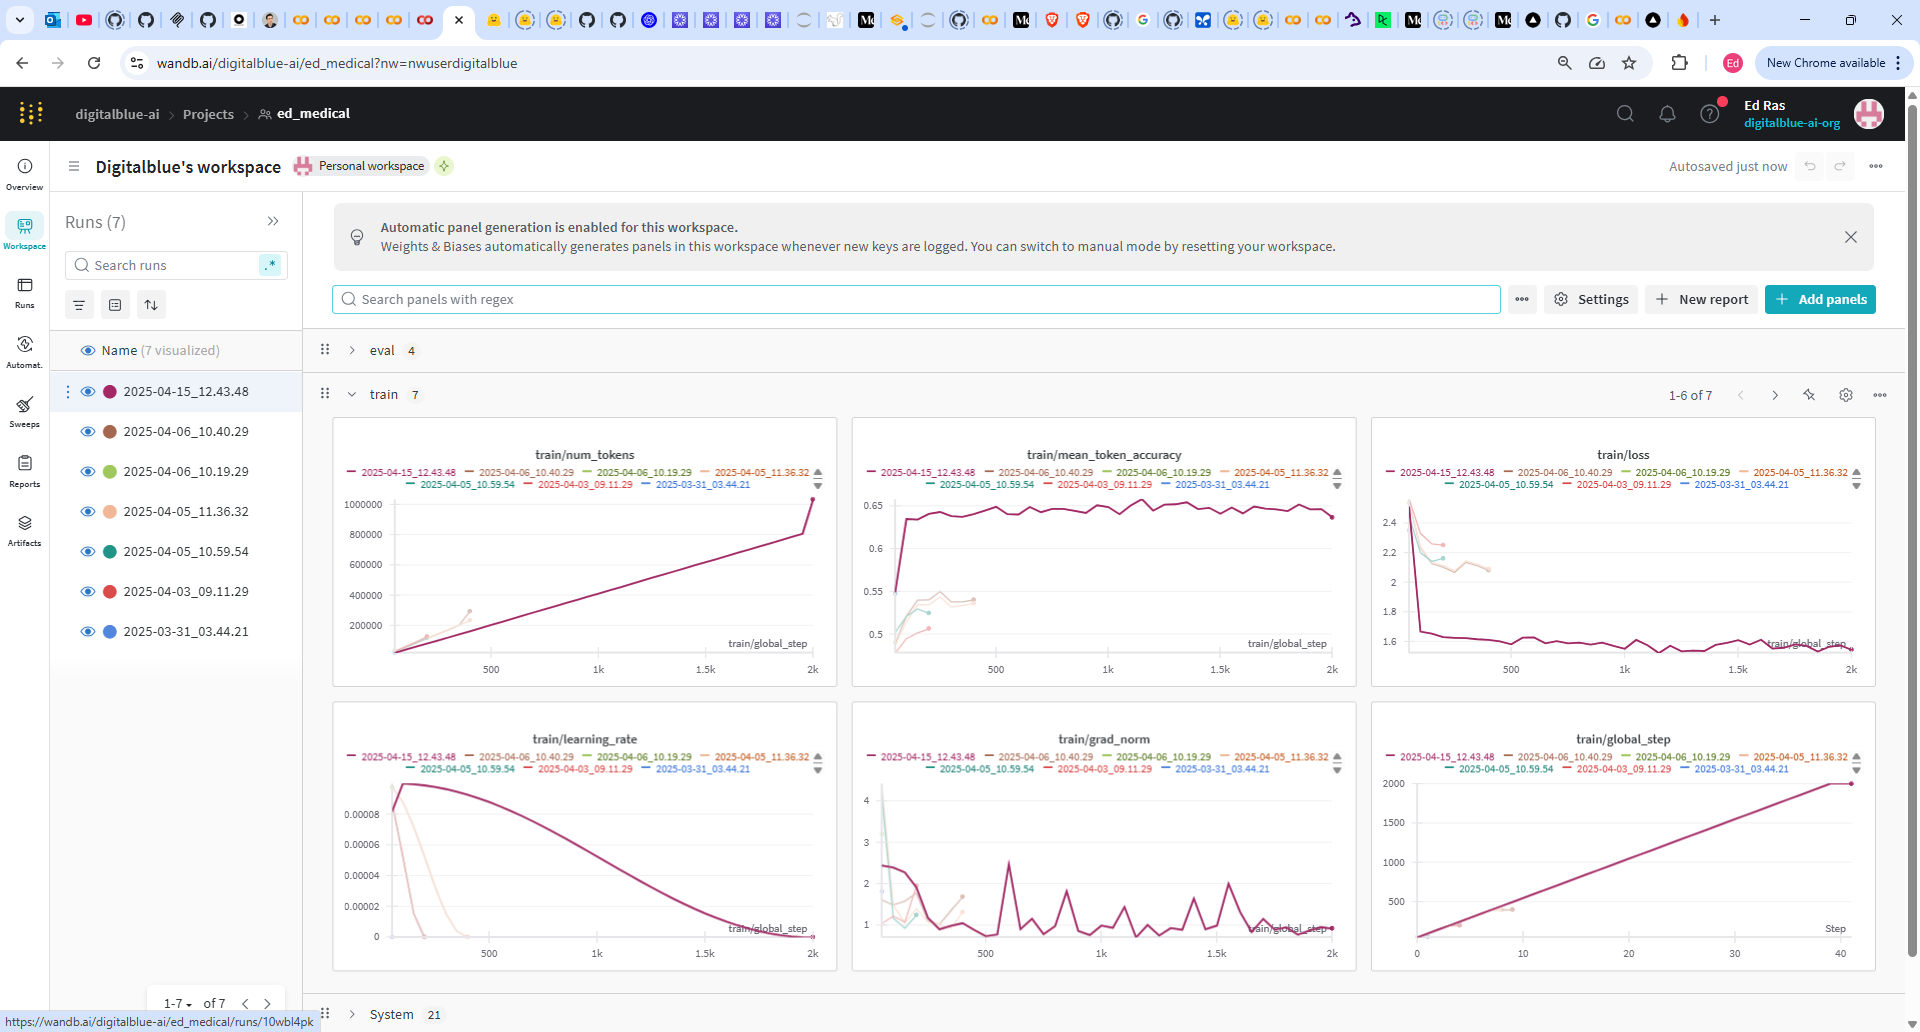

In [9]:
# load pre-processed dataset created in last step from hugging face
#qa_dataset = load_dataset("digitalblue/ed_medical")
#qa_dataset = load_dataset("digitalblue/ed_medical-pubmedqa-artifical") # load only pubmedqa YES rows
qa_dataset = load_dataset("digitalblue/ed_medical-pubmedqa-artifical-with-context") # load only pubmedqa YES rows
qa_dataset

README.md:   0%|          | 0.00/532 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/63.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.96M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/7.96M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/156915 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19614 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19615 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 156915
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 19614
    })
    test: Dataset({
        features: ['text'],
        num_rows: 19615
    })
})

In [10]:
# getting token lengths from training dataset
train_length = []
train_token_length = []
for item in qa_dataset['train']:
  if item['text']:
    train_length.append(len(item['text']))
    tokens = tokenizer.encode(item['text'])
    train_token_length.append(len(tokens))
  else:
    print(item)

In [11]:
len(train_token_length)

156915

In [12]:
# print the min, max and average character lengths and token count lengths for training data
print(min(train_length), max(train_length), sum(train_length)/len(train_length))
print(min(train_token_length), max(train_token_length), sum(train_token_length)/len(train_token_length))

138 4677 786.0767421852595
42 1315 201.8653156167352


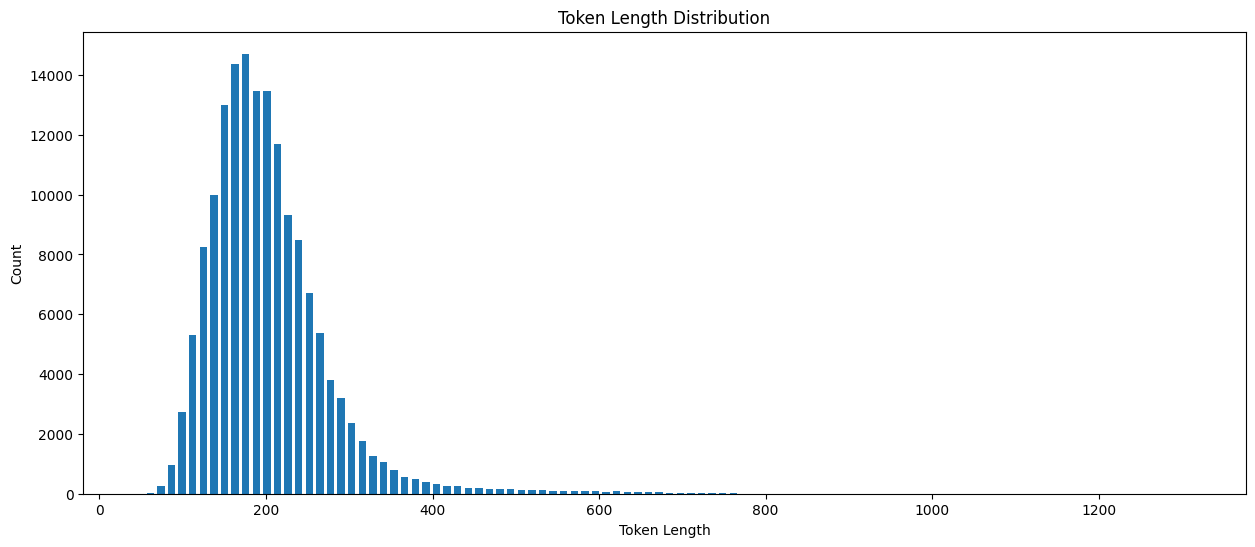

In [13]:
# plot the token lengths
plt.figure(figsize=(15, 6))
plt.hist(train_token_length, rwidth=0.7, bins=100)
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.show()

In [14]:
# avg is now approx 104, but will keep 230 tokens, therefore will create new datasets
# to filter out any rows above this token count
MAX_TOKENS = 250
DATASET_SIZE = 1000
def get_filtered_dataset(dataset, max_tokens, size):
  count = 0
  train_size = round(size * 0.9) # 90% for train
  valid_size = round(size * 0.1) # 10% for eval
  print(f"Train size: {train_size}, Eval size: {valid_size}")

  filtered_train_dataset = []
  for item in dataset['train']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_train_dataset.append(item)
        count += 1
      if count >= train_size:
        break

  count = 0
  filtered_eval_dataset = []
  for item in dataset['validation']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_eval_dataset.append(item)

        count += 1
      if count >= valid_size:
        break

  return filtered_train_dataset, filtered_eval_dataset

In [15]:
qa_train, qa_val = get_filtered_dataset(qa_dataset, MAX_TOKENS, DATASET_SIZE)
qa_train = Dataset.from_list(qa_train)
qa_val = Dataset.from_list(qa_val)
print(qa_train)
print(qa_val)

Train size: 900, Eval size: 100
Dataset({
    features: ['text'],
    num_rows: 900
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [17]:
qa_val[10]

{'text': '<s>[INST] Given this context: More than one half of lower respiratory cultures are negative for ventilator-associated pneumonia (VAP) and final reporting requires 72 hours to 96 hours. A previous retrospective study concluded that preliminary bronchoalveolar lavage (BAL) culture results (pBAL), reported at approximately 24 hours, accurately predicted final BAL culture results (fBAL). Our objective was to verify the predictive value of pBALs for fBALs, and evaluate the use of insignificant (1-99,999 cfu/mL) pBALs for rapid discontinuation of empirical antibiotics. Question: Does utility of preliminary bronchoalveolar lavage result in suspected ventilator-associated pneumonia? [/INST] Preliminary BALs were highly predictive for final results. Using insignificant pBALs appears to be a safe strategy for promptly discontinuing empirical antibiotics in trauma patients with suspected VAP. </s>'}

In [18]:
# set constants
MAX_SEQUENCE_LENGTH = 230 # calculated from avg token lenght in dataset

# Run name for saving the model in the hub
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{project_name}-{RUN_NAME}"
HUB_MODEL_NAME = f"{hf_username}/{PROJECT_RUN_NAME}"

# qlora hyper params
LORA_R = 16 # Reduce LoRA rank (lower = less memory) , initial = 32
LORA_ALPHA = 32 # Lower alpha , initial = 64
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]
LORA_DROPOUT = 0.05
QUANT_4_BIT = True

# training hyper params
EPOCHS = 3
BATCH_SIZE = 4  # Reduce batch size , initial = 4
GRADIENT_ACCUMULATION_STEPS = 8  # Simulate batch size 8, initial = 1
LEARNING_RATE = 2e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"
STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

In [19]:
response_template = " [/INST] "
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [20]:
lora_params = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type="CAUSAL_LM"
)

In [21]:
training_params = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    #eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if True else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
    #neftune_noise_alpha=5 # using NEFTune as describe in SFT Trainer docs for increased conversational quality
)

In [22]:
!nvidia-smi

Sun May 11 04:10:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             32W /   70W |    6652MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# clear gpu memory
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [24]:
# Prepare the model for k-bit training (important for 4-bit)
model = prepare_model_for_kbit_training(model)

In [25]:
model = get_peft_model(model, lora_params)

In [26]:
trainer = SFTTrainer(
    model=model,
    train_dataset=qa_train,
    eval_dataset=qa_val,
    peft_config=lora_params,
    args=training_params
)


Converting train dataset to ChatML:   0%|          | 0/900 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [27]:
#torch.cuda.empty_cache()
trainer.train()
trainer.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Model saved to HuggingFace as: {PROJECT_RUN_NAME}")
model.save_pretrained(PROJECT_RUN_NAME)


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
50,1.693400


wandb: Adding directory to artifact (./ed_medical-2025-05-11_04.05.52/checkpoint-84)... Done. 0.6s
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


README.md:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Model saved to HuggingFace as: ed_medical-2025-05-11_04.05.52


In [28]:
results = trainer.evaluate()
print(results)


{'eval_loss': 1.4443223476409912, 'eval_runtime': 172.7306, 'eval_samples_per_second': 0.579, 'eval_steps_per_second': 0.579}


In [29]:
wandb.finish()

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁██
train/global_step,▁██
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
train/mean_token_accuracy,▁█▇
train/num_tokens,▁▇█


In [30]:
!zip -r ed_medical-2025-05-11_04.05.52.zip ed_medical-2025-05-11_04.05.52

  adding: ed_medical-2025-05-11_04.05.52/ (stored 0%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/ (stored 0%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/rng_state.pth (deflated 25%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/adapter_model.safetensors (deflated 7%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/training_args.bin (deflated 51%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/optimizer.pt (deflated 9%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/trainer_state.json (deflated 55%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/special_tokens_map.json (deflated 74%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/tokenizer.model (deflated 55%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/scheduler.pt (deflated 57%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/tokenizer.json (deflated 85%)
  adding: ed_medical-2025-05-11_04.05.52/checkpoint-84/tokenizer_config.json (deflated 66%)


In [31]:
!ls -la

total 242888
drwxr-xr-x 1 root root      4096 May 11 07:10 .
drwxr-xr-x 1 root root      4096 May 11 03:49 ..
drwxr-xr-x 4 root root      4096 May  8 13:38 .config
drwx------ 6 root root      4096 May 11 03:50 drive
drwxr-xr-x 3 root root      4096 May 11 07:06 ed_medical-2025-05-11_04.05.52
-rw-r--r-- 1 root root 248680821 May 11 07:10 ed_medical-2025-05-11_04.05.52.zip
drwxr-xr-x 1 root root      4096 May  8 13:38 sample_data
drwxr-xr-x 3 root root      4096 May 11 04:17 wandb


In [32]:
!cp ed_medical-2025-05-11_04.05.52.zip /content/drive/MyDrive/

In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
# from google.colab import runtime
# runtime.unassign()

## 5. Evaluate the models - generate evaluation data
At this step the fine-tuned model created in the previous step can be re-loaded without need to re-run step 4. Generated responses will be collected, in addition to the base model to use as a benchmark.

The prompts to generate the responses are 50 samples from the **test** set, which was not used for fine-tuning.

The generated response for each model are then saved to HuggingFace hub for later analysis.

In [6]:
# define models saved to huggingface hub from previous step
MODEL_A = "digitalblue/ed_medical-2025-04-03_09.11.29" # trained on 200 rows
MODEL_B = "digitalblue/ed_medical-2025-04-05_10.59.54" # trained on 800 rows
MODEL_C = "digitalblue/ed_medical-2025-04-05_11.36.32" # trained on 1600 rows
MODEL_D = "digitalblue/ed_medical-2025-04-06_10.40.29" # trained on 1600 rows with NEFTune
MODEL_E = "digitalblue/ed_medical-2025-04-15_12.43.48" # trained on 8000 rows of pubmedqa only w/ NEFTune
MODEL_F = "digitalblue/ed_medical-2025-05-05_23.51.25" # trained on 9000 row, lower learing rate, 3 epochs
MODEL_G = "digitalblue/ed_medical-2025-05-08_01.23.37" # trained on 9000 rows, NEFTune false
MODEL_H = "digitalblue/ed_medical-2025-05-11_04.05.52" # trained on 900 row, with context, 3 epochs

In [1]:
# NOTE: Only using model E, F, G, H

In [8]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [9]:
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [11]:
#qa_test = load_dataset("digitalblue/ed_medical", split="test[:50]") # first 50 from test set
qa_test = load_dataset("digitalblue/ed_medical-pubmedqa-artifical", split="test[:50]") # load only pubmedqa YES rows, test set

In [12]:
# split into question and answer list
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [13]:
qa_list[20][0] # question

'Do n-glycans of human amniotic fluid transferrin stimulate progesterone production in human first trimester trophoblast cells in vitro?'

In [14]:
prompt1 = "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."
#prompt2 = "You are a helpful personalised medical assistant. Provide a friendly personal response to the patients medical question within a paragraph, provide the necessary details. Follow up it they need more information"

def get_model_responses(model_x, qa_list):
  model_responses = []
  for item in qa_list:
    question = item[0]
    # print(item)
    # print(question)
    # print("-----")
    messages = [
      {"role": "system", "content": prompt1},
      {"role": "user", "content": question}
    ]
    inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    outputs = model_x.generate(inputs, max_new_tokens=250, temperature=0.1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    answer = response.split('[/INST] ')[1]  # get text after /INST token
    answer = answer.replace('</s>', '') # remove trailing special token if present
    model_responses.append(answer)
  return model_responses

In [16]:
print(model_base.lm_head.weight[0, :10])
print(model_g.lm_head.weight[0, :10])

tensor([-0.0036,  0.0027, -0.0074, -0.0100,  0.0063,  0.0049, -0.0065,  0.0012,
        -0.0009,  0.0107], device='cuda:0', dtype=torch.float16)
tensor([-0.0036,  0.0027, -0.0074, -0.0100,  0.0063,  0.0049, -0.0065,  0.0012,
        -0.0009,  0.0107], device='cuda:0', dtype=torch.float16)


In [ ]:
model_base_responses_pubmedqa = get_model_responses(model_base, qa_list)

In [ ]:
prompt_base_pubmedqa_dataset = Dataset.from_dict({"text": model_base_responses_pubmedqa})

In [ ]:
prompt_base_pubmedqa_dataset.push_to_hub(f"{hf_username}/model_base_responses_pubmedqa", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_base_responses_pubmedqa/commit/e7d5da1e7221601b91e115833b91cd02cf1c0bd4', commit_message='Upload dataset', commit_description='', oid='e7d5da1e7221601b91e115833b91cd02cf1c0bd4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_base_responses_pubmedqa', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_base_responses_pubmedqa'), pr_revision=None, pr_num=None)

In [ ]:
prompt_base_pubmedqa_dataset[1]

{'text': 'Dose interval between 2 and 4 hours is recommended to achieve the highest bioavailability. '}

In [ ]:
model_e = PeftModel.from_pretrained(model_base, MODEL_E)
model_f = PeftModel.from_pretrained(model_base, MODEL_F)

In [ ]:
model_e_responses = get_model_responses(model_e, qa_list)

In [ ]:
model_f_responses = get_model_responses(model_f, qa_list)

In [ ]:
prompt_e_dataset = Dataset.from_dict({"text": model_e_responses})
prompt_f_dataset = Dataset.from_dict({"text": model_f_responses})

In [ ]:
prompt_e_dataset.push_to_hub(f"{hf_username}/model_e_responses", private=True)
prompt_f_dataset.push_to_hub(f"{hf_username}/model_f_responses", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_f_responses/commit/8ac2484b0737fdde8a0f5f87d6471242afca9fd6', commit_message='Upload dataset', commit_description='', oid='8ac2484b0737fdde8a0f5f87d6471242afca9fd6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_f_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_f_responses'), pr_revision=None, pr_num=None)

In [14]:
model_g = PeftModel.from_pretrained(model_base, MODEL_G)

adapter_config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/793M [00:00<?, ?B/s]

In [19]:
model_g_responses = get_model_responses(model_g, qa_list)
prompt_g_dataset = Dataset.from_dict({"text": model_g_responses})
prompt_g_dataset.push_to_hub(f"{hf_username}/model_g_responses", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_g_responses/commit/18661dc8f0a4129ddbce079efe62700c8f909c5d', commit_message='Upload dataset', commit_description='', oid='18661dc8f0a4129ddbce079efe62700c8f909c5d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_g_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_g_responses'), pr_revision=None, pr_num=None)

In [15]:
model_h = PeftModel.from_pretrained(model_base, MODEL_H)
model_h_responses = get_model_responses(model_h, qa_list)
prompt_h_dataset = Dataset.from_dict({"text": model_h_responses})
prompt_h_dataset.push_to_hub(f"{hf_username}/model_h_responses", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_h_responses/commit/06fce8700b9d76ff82f9434c13399375f50ce198', commit_message='Upload dataset', commit_description='', oid='06fce8700b9d76ff82f9434c13399375f50ce198', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_h_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_h_responses'), pr_revision=None, pr_num=None)

In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
from google.colab import runtime
runtime.unassign()

## 6. Evaluate fine tuned models - get metrics from generated responses
In this final step, the generated response can be reloaded from HuggingFace to evaluate and calculate metrics against the expected responses in **test** dataset.

In [16]:
qa_test = load_dataset("digitalblue/ed_medical-pubmedqa-artifical", split="test[:50]") # load only pubmedqa YES rows, test set

In [17]:
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [18]:
qa_list[20][1] # index 1 is dataset real response

'The results suggest that amnion-transferrin and especially its N-glycans modulate the endocrine function of trophoblasts in culture by up regulating progesterone secretion.'

In [19]:
qa_references = [item[1] for item in qa_list] # get list of reference responses

In [20]:
# load saved response data to evaluate
model_base_pubmedqa_dataset = load_dataset("digitalblue/model_base_responses_pubmedqa")
model_e_dataset = load_dataset("digitalblue/model_e_responses")
model_f_dataset = load_dataset("digitalblue/model_f_responses")
model_g_dataset = load_dataset("digitalblue/model_g_responses")
model_h_dataset = load_dataset("digitalblue/model_h_responses")

README.md:   0%|          | 0.00/267 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/267 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/267 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/266 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/263 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [29]:
# convert to list
base_pubmedqa_response_list = model_base_pubmedqa_dataset['train']['text'][:50]
e_response_list = model_e_dataset['train']['text'][:50]
f_response_list = model_f_dataset['train']['text'][:50]
g_response_list = model_g_dataset['train']['text']
h_response_list = model_h_dataset['train']['text']

In [30]:
def calc_rouge_metric(references, predictions):
  rouge = evaluate.load('rouge')
  results = rouge.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_bleu_metric(references, predictions):
  bleu = evaluate.load('bleu')
  results = bleu.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_meteor_metric(references, predictions):
  meteor = evaluate.load('meteor')
  results = meteor.compute(
    predictions=predictions,
    references=[[ref] for ref in references]
  )
  return results

def calc_bert_score(references, predictions):
  bert_scorer = BERTScorer(model_type='bert-base-uncased')
  P = []
  R = []
  F1 = []

  for i in range(len(predictions)):
    p_i, r_i, f1_i = bert_scorer.score([predictions[i]], [references[i]])
    P.append(p_i)
    R.append(r_i)
    F1.append(f1_i)
  results = {
    'P': np.mean(P),
    'R': np.mean(R),
    'F1': np.mean(F1)
  }
  return results

In [31]:
rouge_base_pubmedqa = calc_rouge_metric(qa_references, base_pubmedqa_response_list)
rouge_e = calc_rouge_metric(qa_references, e_response_list)
rouge_f = calc_rouge_metric(qa_references, f_response_list)
rouge_g = calc_rouge_metric(qa_references, g_response_list)
rouge_h = calc_rouge_metric(qa_references, h_response_list)

In [32]:
print(rouge_base_pubmedqa)
print(rouge_e)
print(rouge_f)
print(rouge_g)
print(rouge_h)

{'rouge1': np.float64(0.26328473964307153), 'rouge2': np.float64(0.07937912538217656), 'rougeL': np.float64(0.18786841702419282), 'rougeLsum': np.float64(0.18878004623214462)}
{'rouge1': np.float64(0.263218379753081), 'rouge2': np.float64(0.07624340373229432), 'rougeL': np.float64(0.19380980070682116), 'rougeLsum': np.float64(0.19417306659604835)}
{'rouge1': np.float64(0.263197307016511), 'rouge2': np.float64(0.07898295649206828), 'rougeL': np.float64(0.19925342907701712), 'rougeLsum': np.float64(0.19917414526155192)}
{'rouge1': np.float64(0.2138327372000946), 'rouge2': np.float64(0.059210807794686446), 'rougeL': np.float64(0.15098541311199265), 'rougeLsum': np.float64(0.16124550725413006)}
{'rouge1': np.float64(0.2637618500720388), 'rouge2': np.float64(0.10223797199683642), 'rougeL': np.float64(0.2046431306067485), 'rougeLsum': np.float64(0.20504087032765383)}


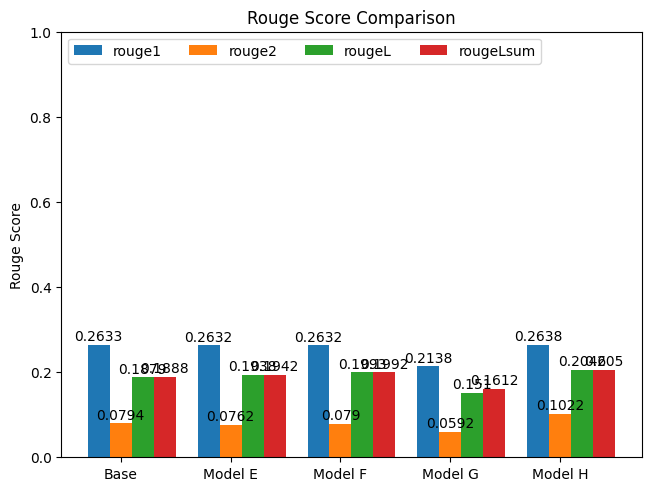

In [33]:
# plot rouge scores
rouge_dict = {
    'rouge1': (rouge_base_pubmedqa['rouge1'], rouge_e['rouge1'], rouge_f['rouge1'], rouge_g['rouge1'], rouge_h['rouge1']),
    'rouge2': (rouge_base_pubmedqa['rouge2'], rouge_e['rouge2'], rouge_f['rouge2'], rouge_g['rouge2'], rouge_h['rouge2']),
    'rougeL': (rouge_base_pubmedqa['rougeL'], rouge_e['rougeL'], rouge_f['rougeL'], rouge_g['rougeL'], rouge_h['rougeL']),
    'rougeLsum': (rouge_base_pubmedqa['rougeLsum'], rouge_e['rougeLsum'], rouge_f['rougeLsum'], rouge_g['rougeLsum'], rouge_h['rougeLsum'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in rouge_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Rouge Score')
ax.set_title('Rouge Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [34]:
bleu_base_pubmedqa = calc_bleu_metric(qa_references, base_pubmedqa_response_list)
bleu_e = calc_bleu_metric(qa_references, e_response_list)
bleu_f = calc_bleu_metric(qa_references, f_response_list)
bleu_g = calc_bleu_metric(qa_references, g_response_list)
bleu_h = calc_bleu_metric(qa_references, h_response_list)

In [35]:
print(bleu_base_pubmedqa)
print(bleu_e)
print(bleu_f)
print(bleu_g)
print(bleu_h)

{'bleu': 0.03138988119399103, 'precisions': [0.3380281690140845, 0.07929176289453425, 0.029623698959167333, 0.010842368640533779], 'brevity_penalty': 0.579500168504768, 'length_ratio': 0.6470023980815348, 'translation_length': 1349, 'reference_length': 2085}
{'bleu': 0.032379811967089916, 'precisions': [0.3113456464379947, 0.07094133697135062, 0.025423728813559324, 0.008784773060029283], 'brevity_penalty': 0.687062637645857, 'length_ratio': 0.7270983213429256, 'translation_length': 1516, 'reference_length': 2085}
{'bleu': 0.0326166306491595, 'precisions': [0.3112278397898884, 0.07196198234894773, 0.025298664792691498, 0.00873998543335761], 'brevity_penalty': 0.6914195086171018, 'length_ratio': 0.7304556354916067, 'translation_length': 1523, 'reference_length': 2085}
{'bleu': 0.021269429662351482, 'precisions': [0.1367226770070372, 0.032402719513959205, 0.01049103890426927, 0.004403346543372964], 'brevity_penalty': 1.0, 'length_ratio': 3.339568345323741, 'translation_length': 6963, 'ref

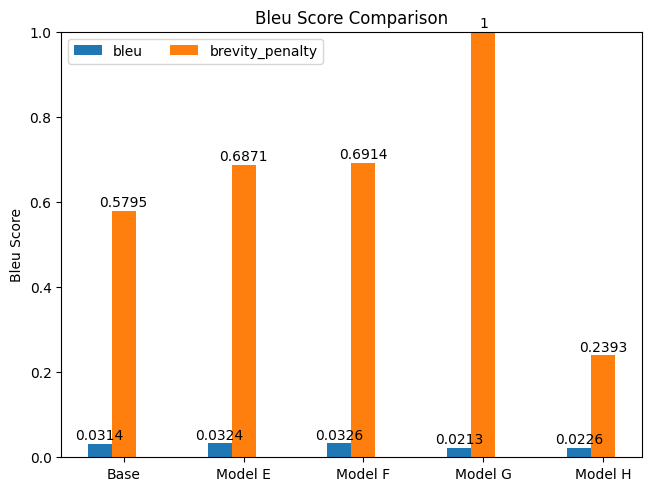

In [39]:
# plot bleu scores
bleu_dict = {
    'bleu': (bleu_base_pubmedqa['bleu'], bleu_e['bleu'], bleu_f['bleu'], bleu_g['bleu'], bleu_h['bleu']),
    'brevity_penalty': (bleu_base_pubmedqa['brevity_penalty'], bleu_e['brevity_penalty'], bleu_f['brevity_penalty'], bleu_g['brevity_penalty'], bleu_h['brevity_penalty'])
}

model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bleu_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bleu Score')
ax.set_title('Bleu Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [40]:
meteor_base_pubmedqa = calc_meteor_metric(qa_references, base_pubmedqa_response_list)
meteor_e = calc_meteor_metric(qa_references, e_response_list)
meteor_f = calc_meteor_metric(qa_references, f_response_list)
meteor_g = calc_meteor_metric(qa_references, g_response_list)
meteor_h = calc_meteor_metric(qa_references, h_response_list)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[n

In [41]:
print(meteor_base_pubmedqa)
print(meteor_e)
print(meteor_f)
print(meteor_g)
print(meteor_h)

{'meteor': np.float64(0.18639960354363067)}
{'meteor': np.float64(0.1881447693596208)}
{'meteor': np.float64(0.19384352470409308)}
{'meteor': np.float64(0.26814099277140213)}
{'meteor': np.float64(0.17556055146287494)}


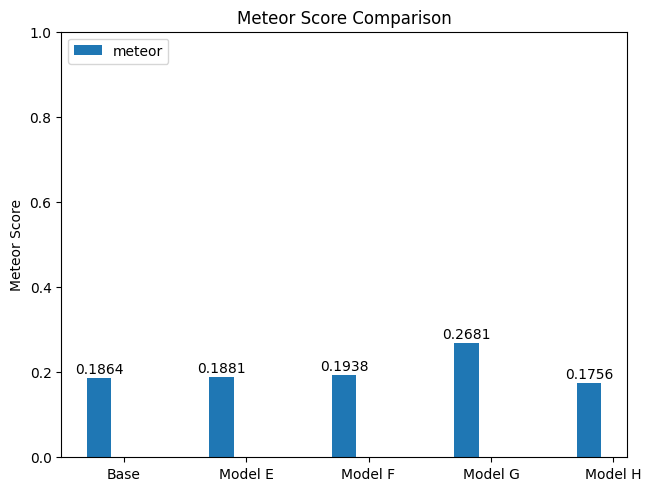

In [42]:
# plot meteor scores
meteor_dict = {
    'meteor': (meteor_base_pubmedqa['meteor'], meteor_e['meteor'], meteor_f['meteor'], meteor_g['meteor'], meteor_h['meteor'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in meteor_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Meteor Score')
ax.set_title('Meteor Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [43]:
bert_score_base_pubmedqa = calc_bert_score(qa_references, base_pubmedqa_response_list)
bert_score_e = calc_bert_score(qa_references, e_response_list)
bert_score_f = calc_bert_score(qa_references, f_response_list)
bert_score_g = calc_bert_score(qa_references, g_response_list)
bert_score_h = calc_bert_score(qa_references, h_response_list)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [44]:
print(bert_score_base_pubmedqa)
print(bert_score_e)
print(bert_score_f)
print(bert_score_g)
print(bert_score_h)

{'P': np.float32(0.6467173), 'R': np.float32(0.58598), 'F1': np.float32(0.6117929)}
{'P': np.float32(0.64296514), 'R': np.float32(0.585245), 'F1': np.float32(0.61016136)}
{'P': np.float32(0.64098334), 'R': np.float32(0.58719736), 'F1': np.float32(0.6097659)}
{'P': np.float32(0.5433609), 'R': np.float32(0.6343017), 'F1': np.float32(0.58330375)}
{'P': np.float32(0.6551912), 'R': np.float32(0.56881934), 'F1': np.float32(0.60660475)}


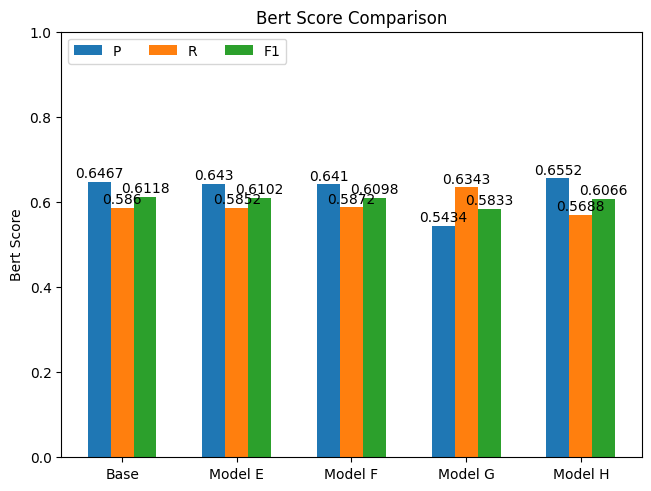

In [45]:
# plot bert scores
bert_score_dict = {
    'P': (bert_score_base_pubmedqa['P'], bert_score_e['P'], bert_score_f['P'], bert_score_g['P'], bert_score_h['P']),
    'R': (bert_score_base_pubmedqa['R'], bert_score_e['R'], bert_score_f['R'], bert_score_g['R'], bert_score_h['R']),
    'F1': (bert_score_base_pubmedqa['F1'], bert_score_e['F1'], bert_score_f['F1'], bert_score_g['F1'], bert_score_h['F1'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bert_score_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bert Score')
ax.set_title('Bert Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [46]:
# human evaluation
def print_response(QA_NUM):
  for i in range(QA_NUM):
    print('-----------------------------------------')
    print('\nTest question: ' + qa_list[i][0])
    print('\nTest answer: ' + qa_list[i][1])
    print('\nBase: ' + base_pubmedqa_response_list[i])
    print('\nModel E: ' + e_response_list[i])
    print('\nModel F: ' + f_response_list[i])
    print('\nModel G: ' + g_response_list[i])
    print('\nModel H: ' + h_response_list[i])

print_response(5)

-----------------------------------------

Test question: Does simvastatin attenuate hepatic sensitization to lipopolysaccharide after partial hepatectomy?

Test answer: These novels findings demonstrate that simvastatin protects the remnant liver against endotoxemic injury following major hepatectomy. Thus, simvastatin reduced LPS-induced leukocyte recruitment and hepatocyte apoptosis in the liver remnant. One key mechanism appears to be related to the inhibition of TNF-alpha formation and function (P-selectin expression) as well as to direct actions on LFA-1 function. Thus, simvastatin may represent a novel therapeutic approach to prevent septic liver damage after partial liver resection.

Base: The results suggest that simvastatin attenuates the increase in the expression of CD14 and TNF-alpha after partial hepatectomy, and this effect may be mediated by the decrease in the expression of ICAM-1. 

Model E: The results suggest that simvastatin attenuates the increase in mRNA expressi

## 7. Evaluation Summary
Evaluation metrics do not show improvement over base model. The Llama 2 model does not disclose its training dataset, however as PubMedQA is public data, there exists the possiblity that it may have already been trained on this dataset.

Alternatively, the training hyperparameters used in training and/or the volume of data used may have been insufficinet for the model to successfully learn the domain.

Next steps:
* Continue to experiment with further hyperparameter tuning
* Increase volume of training data
* Adjust system prompt, and model parameters on inference
* Explore different dataset



---



## 8. Model packaging
This sections explored how to bundle the fine-tuned model with adapters and  including tokenizer, into an LLM that can be downloaded and used standalone. The intention was to investigate how it could be deployed to a cloud provider, and used on edge device or local PC via Ollama.

In [4]:
# clear gpu memory
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [6]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config=quant_config,
    device_map="auto"
    )

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [7]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [8]:
MODEL_A = "digitalblue/ed_medical-2025-04-03_09.11.29" # trained on 200 rows
MODEL_B = "digitalblue/ed_medical-2025-04-05_10.59.54" # trained on 800 rows
MODEL_C = "digitalblue/ed_medical-2025-04-05_11.36.32" # trained on 1600 rows
MODEL_D = "digitalblue/ed_medical-2025-04-06_10.40.29" # trained on 1600 rows with NEFTune
MODEL_E = "digitalblue/ed_medical-2025-04-15_12.43.48" # trained on 8000 rows of pubmedqa only w/ NEFTune
MODEL_F = "digitalblue/ed_medical-2025-05-05_23.51.25" # trained on 9000 row, lower learing rate, 3 epochs

In [10]:
model_e = PeftModel.from_pretrained(model, MODEL_E)

adapter_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

In [12]:
print(model.lm_head.weight[0, :10])
print(model_e.lm_head.weight[0, :10])
print(model_f.lm_head.weight[0, :10])

tensor([-0.0115,  0.0007, -0.0078, -0.0107,  0.0119,  0.0019,  0.0006, -0.0050,
        -0.0156,  0.0156], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward0>)
tensor([-0.0115,  0.0007, -0.0078, -0.0107,  0.0119,  0.0019,  0.0006, -0.0050,
        -0.0156,  0.0156], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward0>)
tensor([-0.0115,  0.0007, -0.0078, -0.0107,  0.0119,  0.0019,  0.0006, -0.0050,
        -0.0156,  0.0156], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward0>)


In [22]:
model_e.print_trainable_parameters()
model_f.print_trainable_parameters()

trainable params: 262,144,000 || all params: 7,008,948,224 || trainable%: 3.7401
trainable params: 262,144,000 || all params: 7,008,948,224 || trainable%: 3.7401


In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."},
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"}
]

In [ ]:
og_output = model_e.generate(tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda"), max_new_tokens=250)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
tokenizer.decode(og_output[0], skip_special_tokens=False)

'<s> [INST] <<SYS>>\nYou are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise.\n<</SYS>>\n\nDoes methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies? [/INST] Methylphenidate improves the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies. </s>'

In [ ]:
base_output = model.generate(tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda"), max_new_tokens=250)
tokenizer.decode(base_output[0], skip_special_tokens=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'<s> [INST] <<SYS>>\nYou are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise.\n<</SYS>>\n\nDoes methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies? [/INST] Methylphenidate improves the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies. </s>'

In [23]:
merge_model_e = model_e.merge_and_unload()

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [24]:
merge_model_f = model_f.merge_and_unload()

In [26]:
merge_model_f

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096

In [27]:
save_folder = "digitalblue/model_e_merge_v2"

In [28]:
merge_model_e.save_pretrained(save_folder, safe_serialization=True)

In [29]:
tokenizer.save_pretrained(save_folder)

('digitalblue/model_e_merge_v2/tokenizer_config.json',
 'digitalblue/model_e_merge_v2/special_tokens_map.json',
 'digitalblue/model_e_merge_v2/tokenizer.model',
 'digitalblue/model_e_merge_v2/added_tokens.json',
 'digitalblue/model_e_merge_v2/tokenizer.json')

In [30]:
from huggingface_hub import create_repo

repo_id = "digitalblue/model_e_merge_v2"
create_repo(repo_id, repo_type="model", exist_ok=True, private=True)

RepoUrl('https://huggingface.co/digitalblue/model_e_merge_v2', endpoint='https://huggingface.co', repo_type='model', repo_id='digitalblue/model_e_merge_v2')

In [31]:
merge_model_e.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/digitalblue/model_e_merge_v2/commit/0c6bc4b265b9fede08ba92a522bfe76bbc9d4573', commit_message='Upload tokenizer', commit_description='', oid='0c6bc4b265b9fede08ba92a522bfe76bbc9d4573', pr_url=None, repo_url=RepoUrl('https://huggingface.co/digitalblue/model_e_merge_v2', endpoint='https://huggingface.co', repo_type='model', repo_id='digitalblue/model_e_merge_v2'), pr_revision=None, pr_num=None)

In [32]:
save_folder = "digitalblue/model_f_merge"
merge_model_f.save_pretrained(save_folder, safe_serialization=True)
tokenizer.save_pretrained(save_folder)

repo_id = save_folder
create_repo(repo_id, repo_type="model", exist_ok=True, private=True)

merge_model_f.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/digitalblue/model_f_merge/commit/2cd6789df3d7b46198dc1bdef4e0b6907898813f', commit_message='Upload tokenizer', commit_description='', oid='2cd6789df3d7b46198dc1bdef4e0b6907898813f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/digitalblue/model_f_merge', endpoint='https://huggingface.co', repo_type='model', repo_id='digitalblue/model_f_merge'), pr_revision=None, pr_num=None)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"},
]
pipe = pipeline("text-generation", model="digitalblue/model_e_merge_v2")
pipe(messages)

Device set to use cuda:0


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': "  Hello! I'm LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. hopefully, I can assist you with any questions or topics you'd like to discuss!"}]}]

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."},
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"}
]
pipe(messages)

[{'generated_text': [{'role': 'system',
    'content': 'You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise.'},
   {'role': 'user',
    'content': 'Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?'},
   {'role': 'assistant',
    'content': '  Methylphenidate, a commonly used medication for attention deficit hyperactivity disorder (ADHD), has also been investigated for its potential benefits in treating difficult-to-treat epilepsies in children and adolescents. While the evidence is limited, several studies suggest that methylphenidate may improve the quality of life of these individuals by reducing seizure frequency and severity, improving cognitive function, and enhancing overall well-being. However, more research is needed to fully understand the effects of methylphenidate on these populations.'}]}]

## Print to PDF

In [1]:
#install necessary packages for printing to pdf
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-

In [5]:
#Convert your notebook into PDF
!jupyter nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/Ed LLM FineTuning_PubMedQA.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/Ed LLM FineTuning_PubMedQA.ipynb to pdf
[NbConvertApp] Support files will be in Ed LLM FineTuning_PubMedQA_files/
[NbConvertApp] Making directory ./Ed LLM FineTuning_PubMedQA_files
[NbConvertApp] Writing 263060 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 307341 bytes to /content/drive/My Drive/Colab Notebooks/Ed LLM FineTuning_PubMedQA.pdf
